In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pygplates
import pygmt

from gprm import ReconstructionModel
from gprm.datasets import Rocks, Reconstructions, Paleogeography, Geology
from gprm.utils.raster import to_anchor_plate
from gprm.utils.geometry import nearest_feature

import sys
#sys.path.append('/Users/simon/OneDrive/Andes_works//python/')
sys.path.append('../../andes_paper/python/')
import joyful_geochemistry as joy
import joyful_mapping as joymap
from time_series import lowess

import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2


########## Geochemistry Inputs
#df = joy.geochem_from_csv('../datafiles/geochem_merge_20221026.csv')
df = joy.geochem_from_csv('../datafiles/geochem_global_20230124.csv',
                          longitude_field_name='longitude', latitude_field_name='latitude')
df = df[df['land_mask']>0.5].reset_index(drop=True)

orogen = ['Cordilleran', 
          #'Terra Australis', 
          #'Solonker', 
          #'Indosinian', 
          #'Variscan-Hercynian',
          #'Scotian',
          #'Uralian',
          #'Mongol',
          #'Kazakh',
          #'Caledonia',
          #'Alpine-Himalayan'
]
    
df = joymap.select_orogens(df,gdf=None, 
                           orogen_names=orogen, 
                           continent_names=[
                               'North America'
                           ]
                          )

model_dir = '../../andes_paper/luffi/REM_surfaces_csv/'
gc_interpolator_dict = joy.make_gc_interpolator_dict(model_dir)


In [2]:
M2021 = Reconstructions.fetch_Merdith2021()
subduction_lookup_time_step = 10.

sz_lookup = {}
for reconstruction_time in np.arange(0,1001,subduction_lookup_time_step):
    snapshot = M2021.plate_snapshot(reconstruction_time=reconstruction_time)
    szs = snapshot.get_boundary_features(boundary_types=['subduction'])
    sz_lookup[reconstruction_time] = szs


def apply_nearest_feature(point, lookup_dict):
    
    return nearest_feature(pygplates.PointOnSphere(point.geometry.y, point.geometry.x), 
                           lookup_dict[point['AnalysisAge']])*pygplates.Earth.mean_radius_in_kms


In [3]:
time_bin_size = subduction_lookup_time_step
space_bin_size = 5

#calibration = 'Hu'
#mohometer_selection = ['la_yb_elevation']

calibration = 'luffi'
mohometer_selection = 50

reconstruction_model = M2021

if isinstance(mohometer_selection, list):
    mohometer_description_string = '|'.join(mohometer_selection)
else:
    mohometer_description_string = str(mohometer_selection)
    
    
    
df_filt = joy.filter_the_database(df, 
                                  filter_method=calibration,
                                  age_min=0.1, 
                                  age_max=1000.)  
    

df_filt['AnalysisAge'] = np.round(df_filt['age']/subduction_lookup_time_step) * subduction_lookup_time_step

df_filt = M2021.assign_plate_ids(df_filt)

df_filt = M2021.reconstruct_to_time_of_appearance(df_filt, ReconstructTime='AnalysisAge')

df_filt['distance_to_sz'] = df_filt.apply(lambda x: apply_nearest_feature(x, sz_lookup), axis=1)



Number of samples after basic filtering 161101
Final number of samples passed = 82890


TODO implement min/max elevation cutoffs


/var/folders/k2/jz_0twls1q13vbr87bqwdtr40000gn/T/ipykernel_58355/3599436558.py:21: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in age_groups:


0.0 2166.814757813385 174.480222267772 31
10.0 1927.9433504273497 176.6045853889517 23
20.0 2105.210190004901 219.96305435293888 24
30.0 2194.5190741992933 160.05786174321733 42
40.0 2771.4560441475505 201.41411175391806 30
50.0 2154.2453386813945 293.14313651878433 15
60.0 2767.7694994988265 215.27755280413328 19
70.0 2661.2573880341874 185.47621810644813 28
80.0 2459.800374213669 382.67821546169966 14
90.0 2023.0606475272016 310.2622733121002 9
100.0 2366.5374034956394 127.46423266161582 39
110.0 1638.4114837900634 304.76791608390516 6
120.0 1875.2366191566573 217.8704096436351 23
130.0 2653.146518526918 406.3669210567607 3
140.0 2039.3698992113427 205.42326908453146 16
150.0 1726.6267416090413 384.6177606241897 11
160.0 1774.7447992223883 227.61472743825354 23
170.0 2768.7961913043073 393.67259442116796 3
180.0 1488.3046194669496 243.76344166992627 25
190.0 852.2061447876144 492.09173149252587 2
200.0 1521.636916615489 337.63936136151136 5
210.0 1301.1848000800574 426.5909122503962 

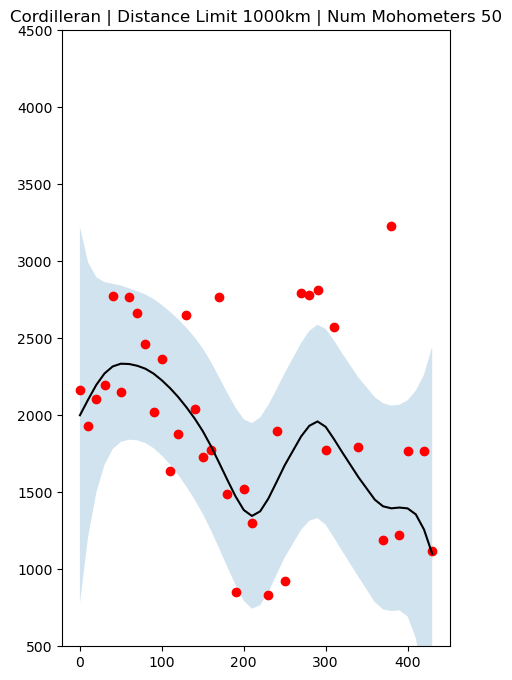

In [4]:
sz_distance_limit = 1000.

df_sel = df_filt[(df_filt['distance_to_sz']<sz_distance_limit)].reset_index(drop=True)

elevation_estimates = joy.get_elevations(df_sel, 
                                         gc_interpolator_dict=gc_interpolator_dict,
                                         calibration=calibration,
                                         mohometer_selection=mohometer_selection)
elevation_estimates = gpd.GeoDataFrame(elevation_estimates.join(df_sel['AnalysisAge']),
                                       geometry=df_sel.geometry)

elevation_estimates['bin_latitude'] = np.round(elevation_estimates.geometry.y/space_bin_size) * space_bin_size
elevation_estimates['bin_longitude'] = np.round(elevation_estimates.geometry.x/space_bin_size) * space_bin_size

age_groups = elevation_estimates.groupby(by=['AnalysisAge'])
age_keys = []
median_elevations = []
elevation_sems = []
nbins_list = []

for name, group in age_groups:
    age_keys.append(name)
    geog_groups = group.groupby(by=['bin_latitude', 'bin_longitude'])
    
    #'''
    fig=pygmt.Figure()
    fig.basemap(frame='afg', projection='N15c', region='d')
    #fig.coast(land='gray', projection='N15c', region='d')
    M2021.polygon_snapshot('continents', name+0.001).plot(fig, fill='grey', pen='0p,gray')
    M2021.plate_snapshot(name).plot_boundaries(fig)
    pygmt.makecpt(cmap='cubhelix', series=[-1000,5000,500], background=True, reverse=True)
    tmp = pd.DataFrame(data={'x':geog_groups.bin_longitude.median().tolist(),
                             'y':geog_groups.bin_latitude.median().tolist(),
                             'z':geog_groups.la_yb_elevation.median().tolist()}).dropna(subset='z')
    #fig.plot(x=geog_groups.bin_longitude.median(), y=geog_groups.bin_latitude.median(), fill=geog_groups.la_yb_elevation.median(), 
    #         style='c0.1c', pen='k', cmap=True)
    if len(tmp)>0:
        fig.plot(x=tmp.x, y=tmp.y, fill=tmp.z, 
                 style='c0.2c', pen='0.2p,black', cmap=True)
    fig.savefig('../images/sequence_M2021/time_series_bins_{:s}_{:0.0f}Ma.png'.format(orogen[0],name))
    #fig.show()
    #'''
    
    binned_list = []
    for n,g in geog_groups:
        data = g.drop(columns=['AnalysisAge', 
                               'geometry', 
                               'bin_latitude', 
                               'bin_longitude']).stack()

        binned_list.append([n[1], 
                            n[0], 
                            name,
                            data.median(),
                            data.quantile(q=0.25),
                            data.quantile(q=0.75)])

    binned_df = pd.DataFrame(data=binned_list, 
                             columns=['x', 'y', 'AnalysisAge',
                                      'median_elevation', 
                                      'q25', 'q75'])

    median_elevations.append(binned_df.median_elevation.median())
    elevation_sems.append(binned_df.median_elevation.sem())
    print(name,
          binned_df.median_elevation.median(),
          binned_df.median_elevation.sem(),
          len(tmp))
    #break
    

ind = np.isnan(median_elevations)
res, rese = lowess(np.array(age_keys)[~ind], np.array(median_elevations)[~ind], xwidth=100)
plt.figure(figsize=(5,8))
plt.plot(age_keys, median_elevations,'ro')
plt.plot(np.array(age_keys)[~ind], res, 'k')
plt.fill_between(np.array(age_keys)[~ind], 
                 y1=res-rese, y2=res+rese, alpha=0.2)
plt.ylim(500,4500)
#plt.xlim(0,540)
plt.title('{:s} | Distance Limit {:0.0f}km | Num Mohometers {:d}'.format(
    orogen[0],
    sz_distance_limit,
    mohometer_selection))
plt.show()


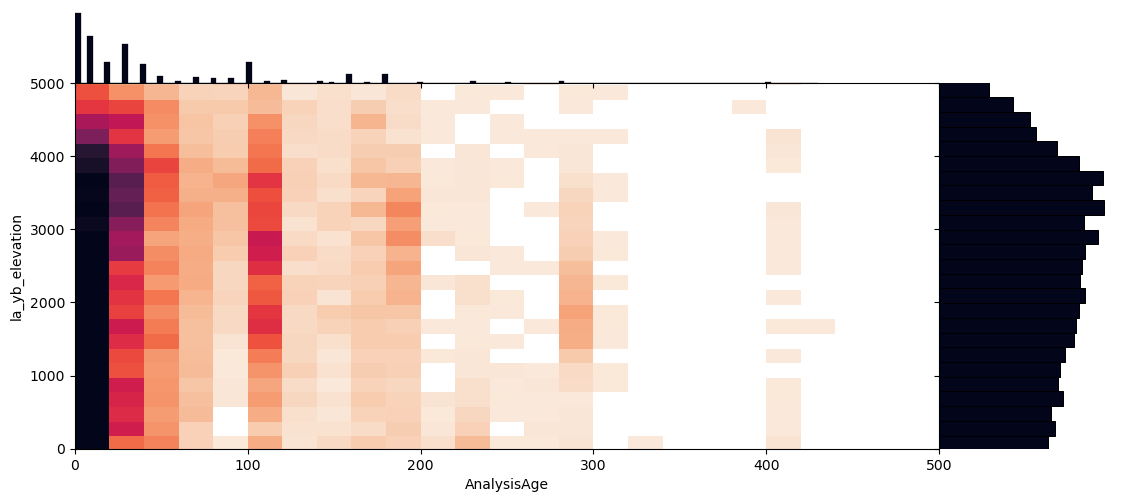

In [5]:
import seaborn as sns

g = sns.JointGrid(data=elevation_estimates, x="AnalysisAge", y="la_yb_elevation", space=0)
g.plot_joint(sns.histplot, thresh=0, pmax=0.75, 
             binwidth=(20,200), cmap="rocket_r")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1)
g.ax_joint.set_xlim(0,500)
g.ax_joint.set_ylim(0,5000)
g.figure.set_figwidth(12)
g.figure.set_figheight(5)

TODO implement min/max elevation cutoffs


/var/folders/k2/jz_0twls1q13vbr87bqwdtr40000gn/T/ipykernel_58355/3232973776.py:20: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in age_groups:


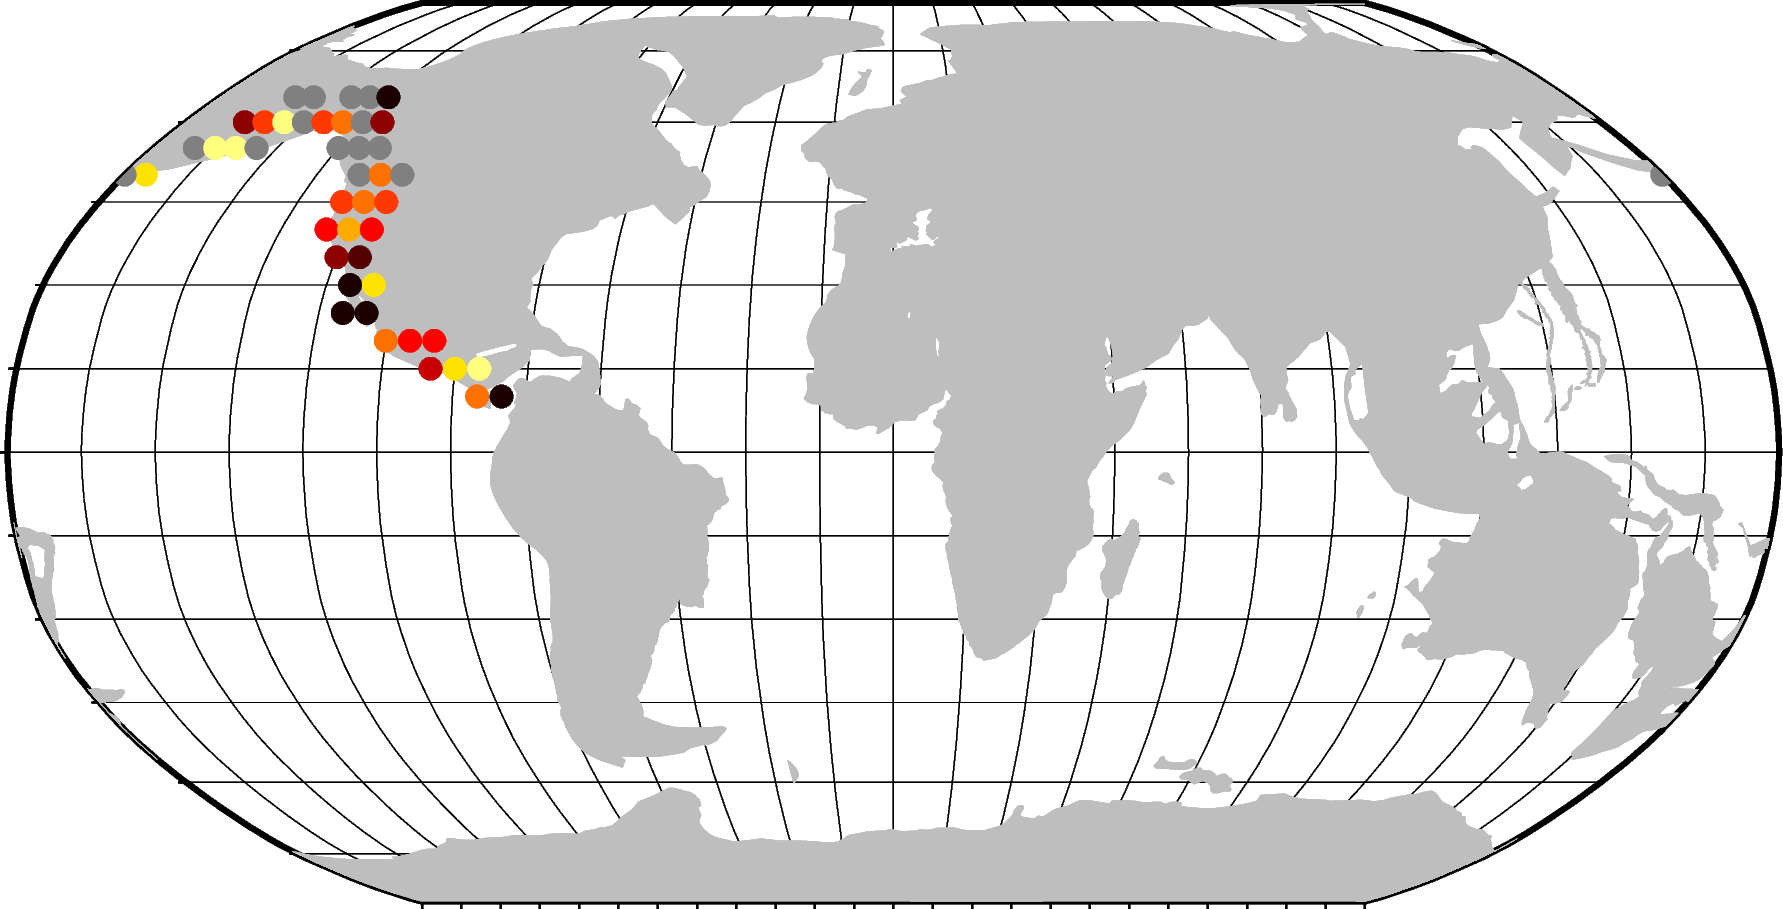

0.0 2166.814757813385 174.480222267772


In [6]:
sz_distance_limit = 1000.

df_sel = df_filt[(df_filt['distance_to_sz']<sz_distance_limit)].reset_index(drop=True)

elevation_estimates = joy.get_elevations(df_sel, 
                                         gc_interpolator_dict=gc_interpolator_dict,
                                         calibration=calibration,
                                         mohometer_selection=mohometer_selection)
elevation_estimates = gpd.GeoDataFrame(elevation_estimates.join(df_sel['AnalysisAge']),
                                       geometry=df_sel.geometry)

elevation_estimates['bin_latitude'] = np.round(elevation_estimates.geometry.y/space_bin_size) * space_bin_size
elevation_estimates['bin_longitude'] = np.round(elevation_estimates.geometry.x/space_bin_size) * space_bin_size

age_groups = elevation_estimates.groupby(by=['AnalysisAge'])
age_keys = []
median_elevations = []
elevation_sems = []

for name, group in age_groups:
    age_keys.append(name)
    geog_groups = group.groupby(by=['bin_latitude', 'bin_longitude'])
    
    
    fig=pygmt.Figure()
    fig.basemap(frame='fg', projection='N15c', region='d')
    #fig.coast(land='gray', projection='N15c', region='d')
    M2021.polygon_snapshot('continents', name+0.01).plot(fig, fill='grey', pen='0p,gray')
    pygmt.makecpt(cmap='hot', series=[-1000,5000,500], background='o', reverse=True)
    fig.plot(x=geog_groups.bin_longitude.median(), y=geog_groups.bin_latitude.median(), fill=geog_groups.la_yb_elevation.median(), style='c0.2c', cmap=True)
    fig.show()
    
    
    binned_list = []
    for n,g in geog_groups:
        data = g.drop(columns=['AnalysisAge', 
                               'geometry', 
                               'bin_latitude', 
                               'bin_longitude']).stack()

        binned_list.append([n[1], 
                            n[0], 
                            name,
                            data.median(),
                            data.quantile(q=0.25),
                            data.quantile(q=0.75)])

    binned_df = pd.DataFrame(data=binned_list, 
                             columns=['x', 'y', 'AnalysisAge',
                                      'median_elevation', 
                                      'q25', 'q75'])

    median_elevations.append(binned_df.median_elevation.median())
    elevation_sems.append(binned_df.median_elevation.sem())
    print(name,
          binned_df.median_elevation.median(),
          binned_df.median_elevation.sem())
    
    break
    


In [7]:
#geog_groups.la_yb_elevation.median().tolist()
for g in geog_groups:
    print(g)
    

((10.0, -85.0),       la_yb_elevation  ce_yb_elevation  lu_hf_elevation  nd_yb_elevation  \
149               NaN              NaN      5571.294814              NaN   
150               NaN              NaN      5571.294814              NaN   
151               NaN              NaN      5689.854987              NaN   
164               NaN              NaN      5689.854987              NaN   
165       5098.927961      4889.703220      4249.993043      4830.360192   
166       5098.927961      4889.703220      4249.993043      4830.360192   
171       3409.064442      3470.771894      1454.948190      3656.717139   
172       3409.064442      3470.771894      1454.948190      3656.717139   
243               NaN              NaN              NaN              NaN   
244               NaN              NaN              NaN              NaN   
255               NaN              NaN              NaN              NaN   
256               NaN              NaN              NaN              NaN